In [1]:
# Install quantum libs
!pip install -q qiskit qiskit-machine-learning pennylane pennylane-qiskit torch qiskit-aer qiskit-algorithms



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.0/797.0 MB 807.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664

In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Classical ML
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report,
    precision_recall_curve, roc_curve, auc
)

# TensorFlow Autoencoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Qiskit
from qiskit_aer import Aer
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# PennyLane
import pennylane as qml

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)


In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

BASE_PATH = "/content/drive/MyDrive"
DATA_DIR = BASE_PATH  # Corrected: files are directly in MyDrive, not in a 'datasets' subfolder

def load_csv(file_name, base_path=DATA_DIR):
    path = os.path.join(base_path, file_name)
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    df = pd.read_csv(path)
    print(f"Loaded {file_name}: shape={df.shape}")
    return df

df_train = load_csv("part1.csv")
df_test2 = load_csv("part2.csv")
df_test3 = load_csv("part3.csv")

Mounted at /content/drive
Loaded part1.csv: shape=(94936, 31)
Loaded part2.csv: shape=(94936, 31)
Loaded part3.csv: shape=(94935, 31)


In [4]:
def calculate_threshold(scores, method="percentile", percentile=97):
    scores = np.asarray(scores)

    if method == "percentile":
        return np.percentile(scores, percentile)
    elif method == "std":
        return np.mean(scores) + 2 * np.std(scores)
    elif method == "iqr":
        q1, q3 = np.percentile(scores, [25, 75])
        iqr = q3 - q1
        return q3 + 1.5 * iqr
    else:
        raise ValueError(f"Unsupported threshold method: {method}")

def normalize_scores(scores):
    scores = np.asarray(scores)
    smin, smax = np.min(scores), np.max(scores)
    return (scores - smin) / (smax - smin + 1e-12)

def evaluate_model(name, y_true, y_pred):
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    roc  = roc_auc_score(y_true, y_pred)

    print(f"\n=== {name} ===")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc:.4f}")
    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))

    return {"precision": prec, "recall": rec, "f1": f1, "roc_auc": roc}

def plot_curves(name, y_true, scores):
    scores = np.asarray(scores)

    # PR curve
    prec, rec, _ = precision_recall_curve(y_true, scores)
    plt.figure(figsize=(6,5))
    plt.plot(rec, prec, label=name)
    plt.title(f"{name} Precision–Recall Curve")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.legend(); plt.grid(True); plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc_val = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_val:.3f})")
    plt.plot([0,1],[0,1],"k--")
    plt.title(f"{name} ROC Curve")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(); plt.grid(True); plt.show()


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_input (InputLayer)           │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 3)              │            99 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstruction (Dense)          │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,353 (32.63 KB)

 Trainable params: 8,353 (32.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.9281 - val_loss: 0.7257 - learning_rate: 0.0010
Epoch 2/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7779 - val_loss: 0.6782 - learning_rate: 0.0010
Epoch 3/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7392 - val_loss: 0.6546 - learning_rate: 0.0010
Epoch 4/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7119 - val_loss: 0.6404 - learning_rate: 0.0010
Epoch 5/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6946 - val_loss: 0.6212 - learning_rate: 0.0010
Epoch 6/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6835 - val_loss: 0.6077 - learning_rate: 0.0010
Epoch 7/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6670 - val_loss: 0.5960 - learning_rate: 0.0010
Epoch 8/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6646 - val_loss: 0.5915 - learning_rate: 0.0010
Epoch 9/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6504 - val_loss: 0.5819 - learning_rate: 0.0010
E

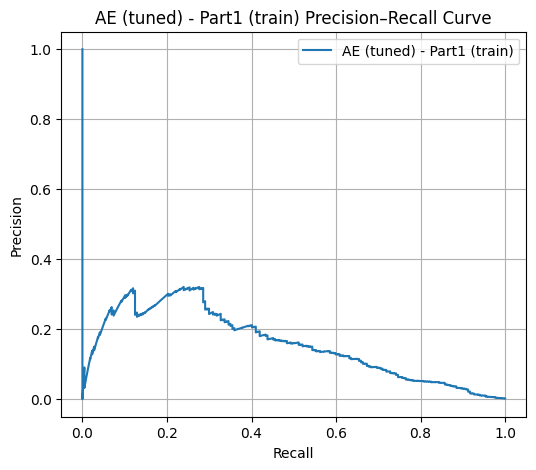

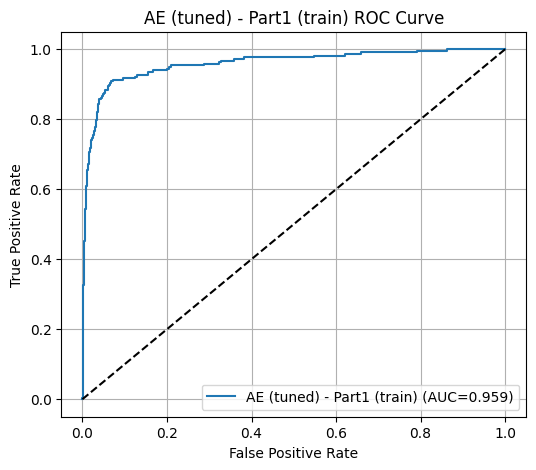


=== Autoencoder (tuned) - Part2 (test2) ===

=== AE (tuned) - Part2 (test2) ===
Precision: 0.2101
Recall:    0.3268
F1-score:  0.2558
ROC-AUC:   0.6624

Confusion matrix:
[[94595   188]
 [  103    50]]

Classification report:
              precision    recall  f1-score   support

           0     0.9989    0.9980    0.9985     94783
           1     0.2101    0.3268    0.2558       153

    accuracy                         0.9969     94936
   macro avg     0.6045    0.6624    0.6271     94936
weighted avg     0.9976    0.9969    0.9973     94936



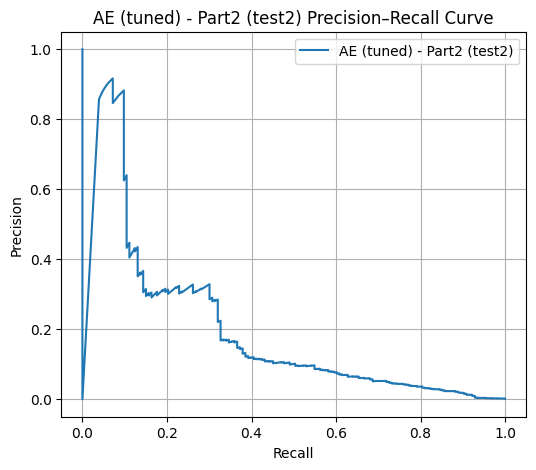

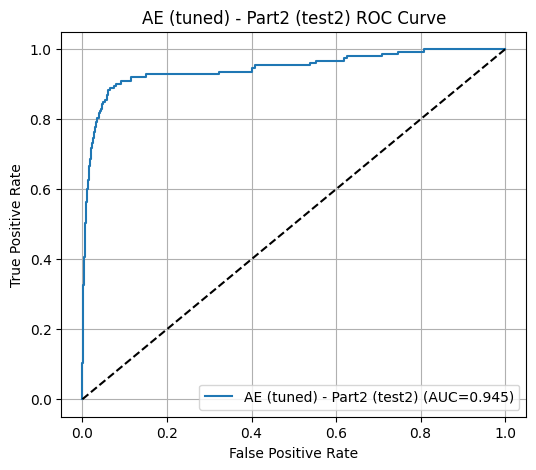


=== Autoencoder (tuned) - Part3 (test3) ===

=== AE (tuned) - Part3 (test3) ===
Precision: 0.0286
Recall:    0.0574
F1-score:  0.0381
ROC-AUC:   0.5274

Confusion matrix:
[[94575   238]
 [  115     7]]

Classification report:
              precision    recall  f1-score   support

           0     0.9988    0.9975    0.9981     94813
           1     0.0286    0.0574    0.0381       122

    accuracy                         0.9963     94935
   macro avg     0.5137    0.5274    0.5181     94935
weighted avg     0.9975    0.9963    0.9969     94935



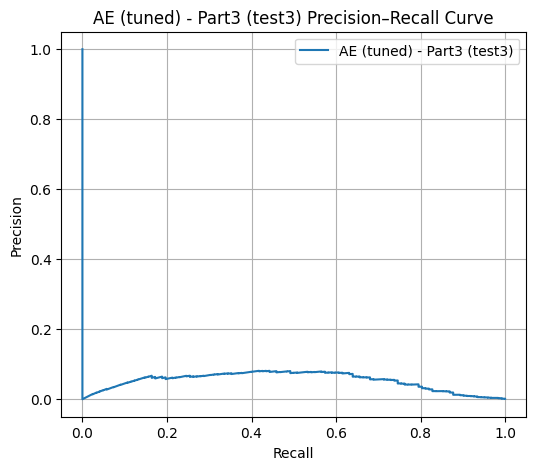

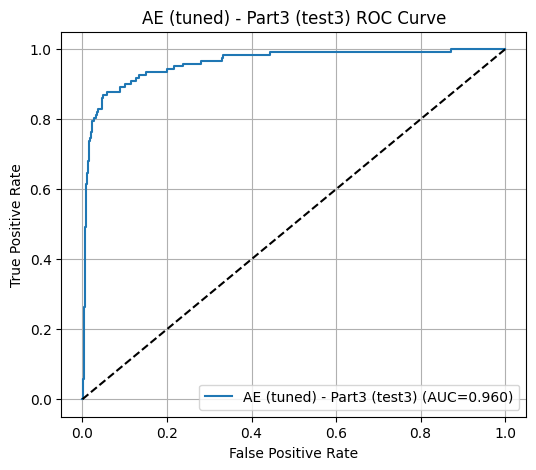

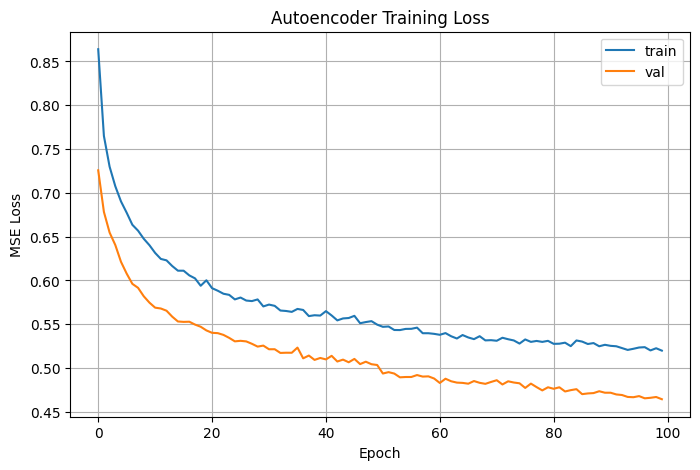

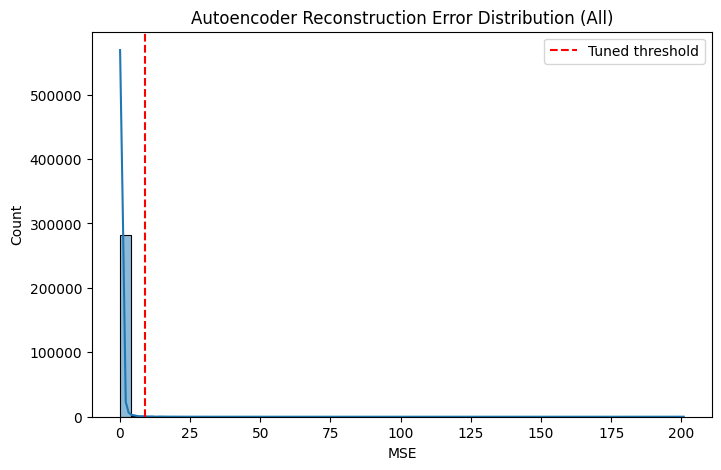

Bottleneck shape: (284807, 3)


In [14]:
#Autoencoder#
# == Combine data and scale ==
df_combined = pd.concat([df_train, df_test2, df_test3], ignore_index=True)

X = df_combined.drop(columns=["Class"])
y_true = df_combined["Class"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define split indices
n_train = len(df_train)
n_test2 = len(df_test2)
n_test3 = len(df_test3)

idx_train = slice(0, n_train)
idx_test2 = slice(n_train, n_train + n_test2)
idx_test3 = slice(n_train + n_test2, n_train + n_test2 + n_test3)

# == Autoencoder definition ==
input_dim = X_scaled.shape[1]

inp = Input(shape=(input_dim,), name="ae_input")

# Encoder
x = Dense(64, activation="relu")(inp)
x = Dropout(0.2)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.2)(x)

latent = Dense(3, activation="relu", name="latent")(x)

# Decoder
x = Dense(32, activation="relu")(latent)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)

out = Dense(input_dim, activation="linear", name="reconstruction")(x)

autoencoder = Model(inputs=inp, outputs=out, name="autoencoder")
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse"
)

autoencoder.summary()

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-5
)

# == Train AE on NORMAL samples from PART 1 only ==
train_mask = np.zeros_like(y_true, dtype=bool)
train_mask[idx_train] = True
normal_train_mask = (y_true == 0) & train_mask

X_train_ae = X_scaled[normal_train_mask]   # only normals from part1
X_all      = X_scaled                      # evaluate on all parts

history = autoencoder.fit(
    X_train_ae, X_train_ae,
    epochs=100,
    batch_size=256,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    shuffle=True,
    verbose=1
)

# == Reconstruction error on ALL data ==
reconstructed = autoencoder.predict(X_all, verbose=0)
ae_mse = np.mean((X_all - reconstructed) ** 2, axis=1)

# === Threshold tuning using ONLY PART 1 ===
scores_train = ae_mse[idx_train]
labels_train = y_true[idx_train]

percentiles = np.linspace(90, 99.9, 50)  # search 90% → 99.9%
best_f1 = -1
best_p = None
best_thr = None
best_prec = None
best_rec = None

for p in percentiles:
    thr = np.percentile(scores_train, p)
    preds = (scores_train > thr).astype(int)
    prec = precision_score(labels_train, preds, zero_division=0)
    rec  = recall_score(labels_train, preds, zero_division=0)
    f1   = f1_score(labels_train, preds, zero_division=0)

    if f1 > best_f1:
        best_f1 = f1
        best_p = p
        best_thr = thr
        best_prec = prec
        best_rec = rec

print(f"\n[AE threshold tuning (Part1 only)]")
print(f"Best percentile: {best_p:.2f}")
print(f"Best threshold:  {best_thr:.4f}")
print(f"Precision:       {best_prec:.4f}")
print(f"Recall:          {best_rec:.4f}")
print(f"F1-score:        {best_f1:.4f}")

ae_thresh = best_thr
y_pred_ae_all = (ae_mse > ae_thresh).astype(int)

print(f"\nAE MSE threshold (tuned): {ae_thresh:.4f}")
print(f"Total AE anomalies: {(y_pred_ae_all == 1).sum()} / {len(y_pred_ae_all)}")

# == Metrics per part ==
def eval_ae_split(name, sl):
    y_split = y_true[sl]
    s_split = ae_mse[sl]
    y_pred_split = y_pred_ae_all[sl]
    print(f"\n=== Autoencoder (tuned) - {name} ===")
    _ = evaluate_model(f"AE (tuned) - {name}", y_split, y_pred_split)
    plot_curves(f"AE (tuned) - {name}", y_split, s_split)

eval_ae_split("Part1 (train)", idx_train)
eval_ae_split("Part2 (test2)", idx_test2)
eval_ae_split("Part3 (test3)", idx_test3)

# Training loss plot
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
plt.legend(); plt.grid(True); plt.show()

# Reconstruction error distribution (all data)
plt.figure(figsize=(8,5))
sns.histplot(ae_mse, bins=50, kde=True)
plt.axvline(ae_thresh, color="red", linestyle="--", label="Tuned threshold")
plt.title("Autoencoder Reconstruction Error Distribution (All)")
plt.xlabel("MSE"); plt.ylabel("Count")
plt.legend(); plt.show()

# == Bottleneck features for downstream models ==
encoder_model = Model(
    inputs=autoencoder.input,
    outputs=autoencoder.get_layer("latent").output
)
X_bottleneck = encoder_model.predict(X_all, verbose=0)
print("Bottleneck shape:", X_bottleneck.shape)



[IF threshold tuning (Part1 only)]
Best percentile: 97.88
Best threshold:  -0.1488
Precision:       0.0601
Recall:          0.5576
F1-score:        0.1085

IF score threshold (tuned): -0.1488
Total IF anomalies: 6030 / 284807

=== Isolation Forest (tuned) - Part1 (train) ===

=== IF (tuned) - Part1 (train) ===
Precision: 0.0601
Recall:    0.5576
F1-score:  0.1085
ROC-AUC:   0.7688

Confusion matrix:
[[92826  1893]
 [   96   121]]

Classification report:
              precision    recall  f1-score   support

           0     0.9990    0.9800    0.9894     94719
           1     0.0601    0.5576    0.1085       217

    accuracy                         0.9790     94936
   macro avg     0.5295    0.7688    0.5489     94936
weighted avg     0.9968    0.9790    0.9874     94936



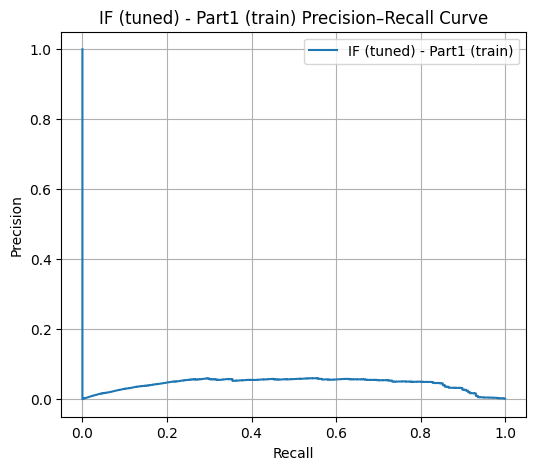

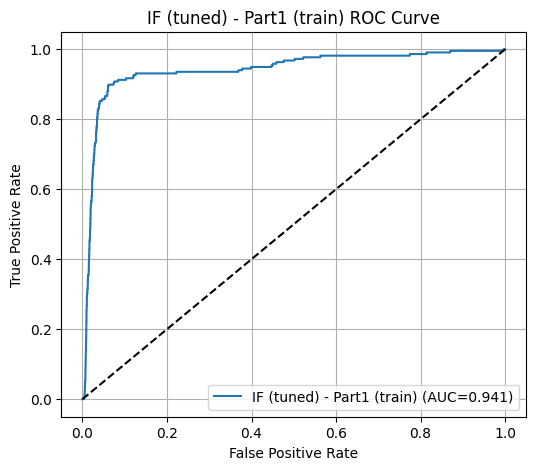


=== Isolation Forest (tuned) - Part2 (test2) ===

=== IF (tuned) - Part2 (test2) ===
Precision: 0.0468
Recall:    0.5490
F1-score:  0.0862
ROC-AUC:   0.7655

Confusion matrix:
[[93072  1711]
 [   69    84]]

Classification report:
              precision    recall  f1-score   support

           0     0.9993    0.9819    0.9905     94783
           1     0.0468    0.5490    0.0862       153

    accuracy                         0.9813     94936
   macro avg     0.5230    0.7655    0.5384     94936
weighted avg     0.9977    0.9813    0.9891     94936



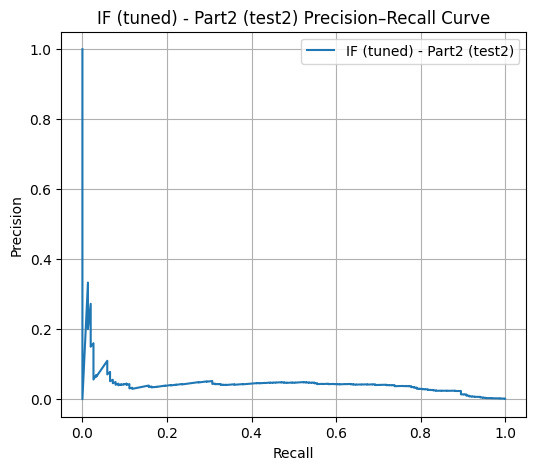

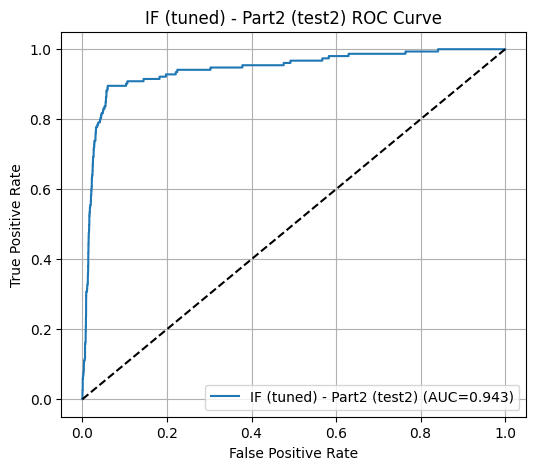


=== Isolation Forest (tuned) - Part3 (test3) ===

=== IF (tuned) - Part3 (test3) ===
Precision: 0.0072
Recall:    0.1311
F1-score:  0.0137
ROC-AUC:   0.5539

Confusion matrix:
[[92608  2205]
 [  106    16]]

Classification report:
              precision    recall  f1-score   support

           0     0.9989    0.9767    0.9877     94813
           1     0.0072    0.1311    0.0137       122

    accuracy                         0.9757     94935
   macro avg     0.5030    0.5539    0.5007     94935
weighted avg     0.9976    0.9757    0.9864     94935



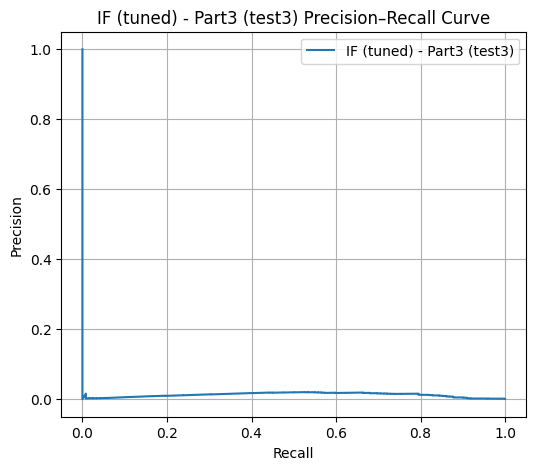

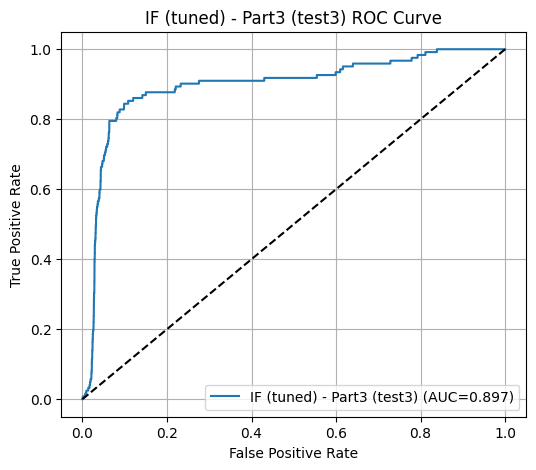

In [6]:
# == Isolation Forest on AE bottleneck (train on Part1 normals only) ==

X_if = X_bottleneck

# Train IF on NORMAL samples from PART 1
train_mask = np.zeros_like(y_true, dtype=bool)
train_mask[idx_train] = True
normal_train_mask_if = (y_true == 0) & train_mask

X_if_train = X_if[normal_train_mask_if]

iso_forest = IsolationForest(
    n_estimators=300,
    contamination=0.002,   # close to true fraud rate
    max_samples=256,
    random_state=42,
    n_jobs=-1,
    bootstrap=False
)

iso_forest.fit(X_if_train)

# Scores on ALL data
iso_scores_raw = iso_forest.decision_function(X_if)  # higher = more normal
iso_scores = -iso_scores_raw                         # higher = more anomalous

# Threshold tuning on PART 1 only
scores_train_if = iso_scores[idx_train]
labels_train_if = y_true[idx_train]

percentiles = np.linspace(90, 99.9, 50)
best_f1 = -1
best_p = None
best_thr = None
best_prec = None
best_rec = None

for p in percentiles:
    thr = np.percentile(scores_train_if, p)
    preds = (scores_train_if > thr).astype(int)
    prec = precision_score(labels_train_if, preds, zero_division=0)
    rec  = recall_score(labels_train_if, preds, zero_division=0)
    f1   = f1_score(labels_train_if, preds, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_p = p
        best_thr = thr
        best_prec = prec
        best_rec = rec

print(f"\n[IF threshold tuning (Part1 only)]")
print(f"Best percentile: {best_p:.2f}")
print(f"Best threshold:  {best_thr:.4f}")
print(f"Precision:       {best_prec:.4f}")
print(f"Recall:          {best_rec:.4f}")
print(f"F1-score:        {best_f1:.4f}")

iso_thresh = best_thr
y_pred_if_all = (iso_scores > iso_thresh).astype(int)

print(f"\nIF score threshold (tuned): {iso_thresh:.4f}")
print(f"Total IF anomalies: {(y_pred_if_all == 1).sum()} / {len(y_pred_if_all)}")

def eval_if_split(name, sl):
    y_split = y_true[sl]
    s_split = iso_scores[sl]
    y_pred_split = y_pred_if_all[sl]
    print(f"\n=== Isolation Forest (tuned) - {name} ===")
    _ = evaluate_model(f"IF (tuned) - {name}", y_split, y_pred_split)
    plot_curves(f"IF (tuned) - {name}", y_split, s_split)

eval_if_split("Part1 (train)", idx_train)
eval_if_split("Part2 (test2)", idx_test2)
eval_if_split("Part3 (test3)", idx_test3)

# Optional normed score for later ensemble / VQC
iso_score_norm = normalize_scores(iso_scores)



[AE+IF Ensemble threshold tuning]
Best percentile: 99.50
Best threshold:  0.2664
Precision:       0.0606
Recall:          0.1768
F1-score:        0.0902

Ensemble threshold (tuned): 0.2664
Ensemble anomalies: 1436 / 284807

=== AE+IF Ensemble (tuned) ===
Precision: 0.0606
Recall:    0.1768
F1-score:  0.0902
ROC-AUC:   0.5860

Confusion matrix:
[[282966   1349]
 [   405     87]]

Classification report:
              precision    recall  f1-score   support

           0     0.9986    0.9953    0.9969    284315
           1     0.0606    0.1768    0.0902       492

    accuracy                         0.9938    284807
   macro avg     0.5296    0.5860    0.5436    284807
weighted avg     0.9970    0.9938    0.9953    284807



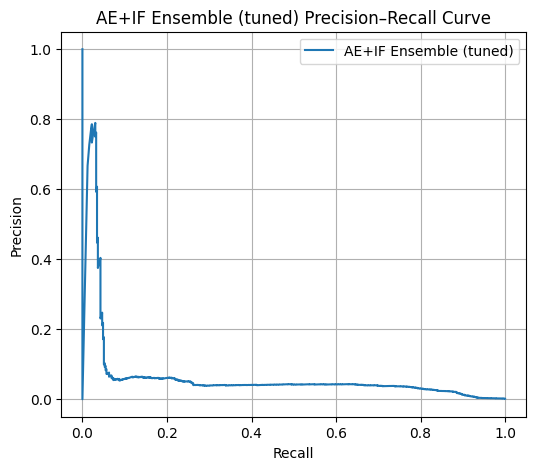

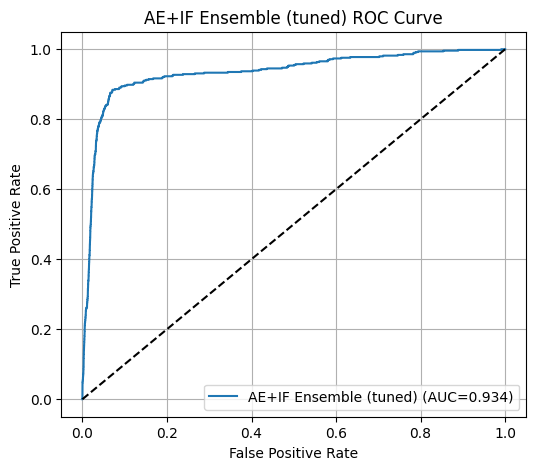

In [7]:
# == Pre-VQC Ensemble: AE + IF ==

# 1) Normalize AE and IF scores (higher = more anomalous)
ae_norm = normalize_scores(ae_mse)      # from AE block
if_norm = normalize_scores(iso_scores)  # from IF block

# Simple fixed weights for now (you can tune later)
w_ae = 0.7
w_if = 0.3

ensemble_scores = w_ae * ae_norm + w_if * if_norm  # higher = more anomalous

# === Threshold tuning for Ensemble (search best percentile by F1) ===
scores = ensemble_scores
labels = y_true  # same as y_true, used in AE block

percentiles = np.linspace(90, 99.9, 50)  # search 90% → 99.9%
best_f1 = -1
best_p = None
best_thr = None
best_prec = None
best_rec = None

for p in percentiles:
    thr = np.percentile(scores, p)
    preds = (scores > thr).astype(int)
    prec = precision_score(labels, preds, zero_division=0)
    rec  = recall_score(labels, preds, zero_division=0)
    f1   = f1_score(labels, preds, zero_division=0)

    if f1 > best_f1:
        best_f1 = f1
        best_p = p
        best_thr = thr
        best_prec = prec
        best_rec = rec

print(f"\n[AE+IF Ensemble threshold tuning]")
print(f"Best percentile: {best_p:.2f}")
print(f"Best threshold:  {best_thr:.4f}")
print(f"Precision:       {best_prec:.4f}")
print(f"Recall:          {best_rec:.4f}")
print(f"F1-score:        {best_f1:.4f}")

ens_thresh = best_thr
y_pred_ens = (scores > ens_thresh).astype(int)

print(f"\nEnsemble threshold (tuned): {ens_thresh:.4f}")
print(f"Ensemble anomalies: {(y_pred_ens == 1).sum()} / {len(y_pred_ens)}")

# Metrics and curves for the ensemble
_ = evaluate_model("AE+IF Ensemble (tuned)", labels, y_pred_ens)
plot_curves("AE+IF Ensemble (tuned)", labels, ensemble_scores)

# Optionally store for later use
ensemble_results = {
    "scores": ensemble_scores,
    "threshold": ens_thresh,
    "y_pred": y_pred_ens,
    "ae_norm": ae_norm,
    "if_norm": if_norm,
}

In [8]:
# == Prepare quantum input features (pre-VQC) ==

# PCA compress AE bottleneck to 4 dims (for 4 qubits)
pca_q = PCA(n_components=4, random_state=42)
latent_pca4 = pca_q.fit_transform(X_bottleneck)  # X_bottleneck from AE block

# Scale latent_pca4 to [-pi, pi] for angle embedding
min_v = latent_pca4.min(axis=0)
max_v = latent_pca4.max(axis=0)
latent_angles = ((latent_pca4 - min_v) / (max_v - min_v + 1e-12)) * (2 * np.pi) - np.pi

# Final feature set for quantum model:
#   - 4 angle features (for qubits)
#   - 2 classical anomaly scores (AE + IF)
X_q = np.column_stack([
    latent_angles,          # shape (n_samples, 4)
    ae_norm.reshape(-1, 1), # AE anomaly score (0-1)
    if_norm.reshape(-1, 1), # IF anomaly score (0-1)
])

y_q = y_true  # labels for quantum training / evaluation

print("X_q shape (for VQC):", X_q.shape)
print("y_q shape:", y_q.shape)


X_q shape (for VQC): (284807, 6)
y_q shape: (284807,)


Quantum train subset shape: (2492, 4) (2492,)
Frauds in subset: 492 Normals: 2000
Epoch 1/3 - train_loss=0.5531 - val_loss=0.5439
Epoch 2/3 - train_loss=0.5201 - val_loss=0.5157
Epoch 3/3 - train_loss=0.4950 - val_loss=0.4933

[VQC threshold tuning (Part1 only)]
Best percentile: 93.03
Best threshold:  0.4948
Precision:       0.0183
Recall:          0.5576
F1-score:        0.0354

VQC anomalies: 26069 / 284807

=== VQC (latent PCA 4D) - Part1 (train) ===

=== VQC (tuned) - Part1 (train) ===
Precision: 0.0183
Recall:    0.5576
F1-score:  0.0354
ROC-AUC:   0.7445

Confusion matrix:
[[88223  6496]
 [   96   121]]

Classification report:
              precision    recall  f1-score   support

         0.0     0.9989    0.9314    0.9640     94719
         1.0     0.0183    0.5576    0.0354       217

    accuracy                         0.9306     94936
   macro avg     0.5086    0.7445    0.4997     94936
weighted avg     0.9967    0.9306    0.9619     94936



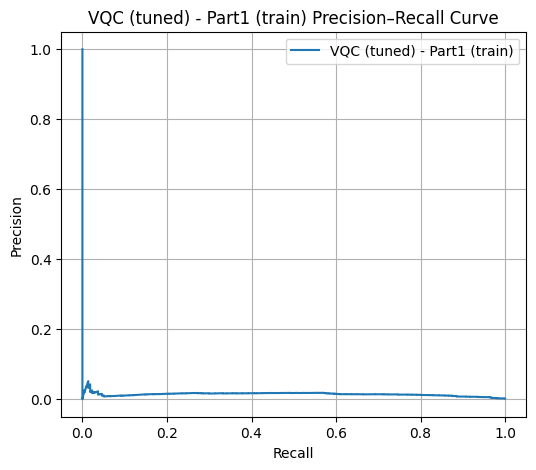

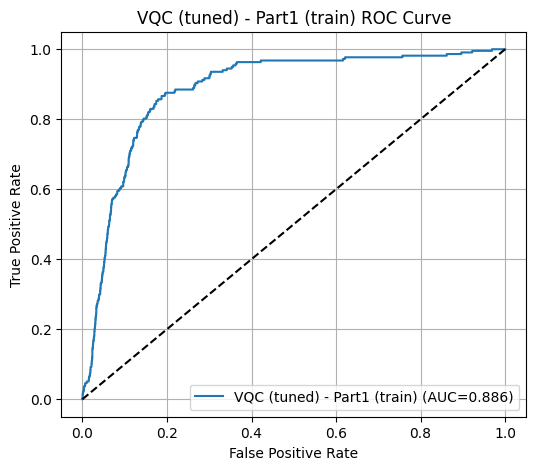


=== VQC (latent PCA 4D) - Part2 (test2) ===

=== VQC (tuned) - Part2 (test2) ===
Precision: 0.0087
Recall:    0.4837
F1-score:  0.0172
ROC-AUC:   0.6976

Confusion matrix:
[[86395  8388]
 [   79    74]]

Classification report:
              precision    recall  f1-score   support

         0.0     0.9991    0.9115    0.9533     94783
         1.0     0.0087    0.4837    0.0172       153

    accuracy                         0.9108     94936
   macro avg     0.5039    0.6976    0.4852     94936
weighted avg     0.9975    0.9108    0.9518     94936



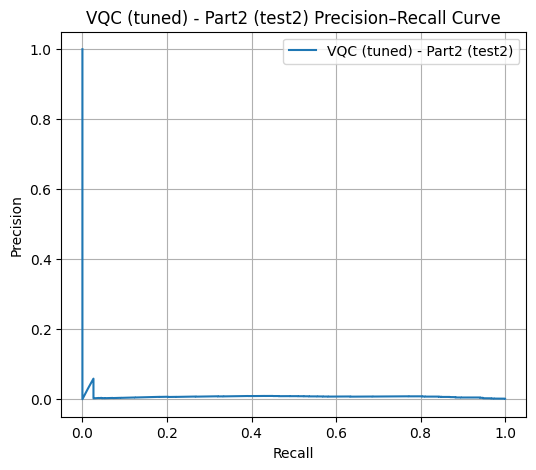

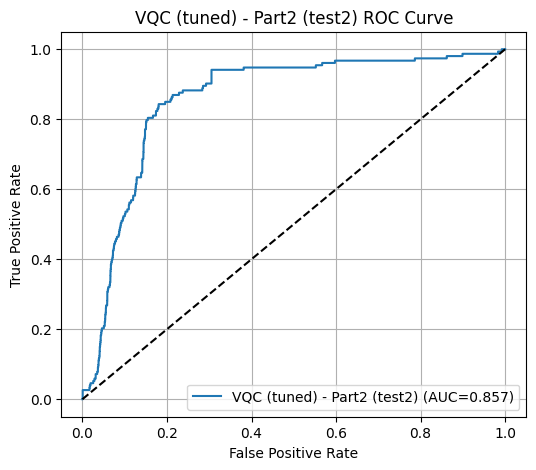


=== VQC (latent PCA 4D) - Part3 (test3) ===

=== VQC (tuned) - Part3 (test3) ===
Precision: 0.0047
Recall:    0.4262
F1-score:  0.0094
ROC-AUC:   0.6554

Confusion matrix:
[[83875 10938]
 [   70    52]]

Classification report:
              precision    recall  f1-score   support

         0.0     0.9992    0.8846    0.9384     94813
         1.0     0.0047    0.4262    0.0094       122

    accuracy                         0.8840     94935
   macro avg     0.5019    0.6554    0.4739     94935
weighted avg     0.9979    0.8840    0.9372     94935



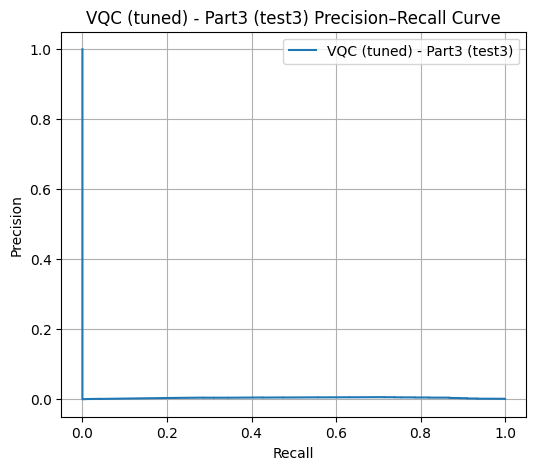

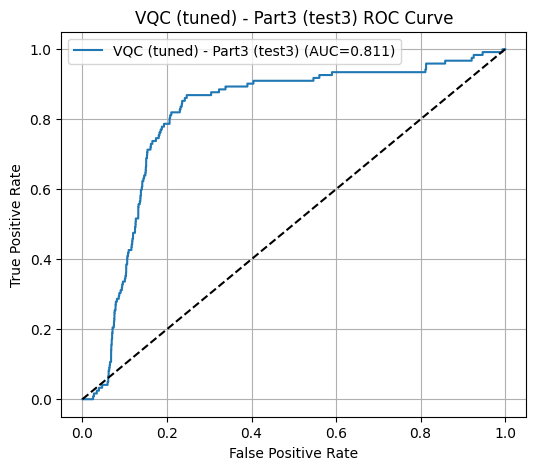

In [9]:
# ===========================
# Fast VQC classifier (Qiskit)
# Uses:
#   - X_q  (from pre-VQC ensemble, shape: [n_samples, 6])
#   - y_q  (labels, 0/1)
# ===========================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# ===== 1) Prepare angle inputs and labels =====

# Use only the first 4 features of X_q as quantum angles
X_q_angles = X_q[:, :4]   # shape (n_samples, 4)
y_q_binary = y_q.astype(np.float32)

# ===== 2) Build a SMALL, STRATIFIED subset for quantum training =====

fraud_idx  = np.where(y_q_binary == 1)[0]
normal_idx = np.where(y_q_binary == 0)[0]

# Use ALL fraud samples + a random subset of normals
n_normals_sample = 2000  # tweak 1000–5000 if you like
rng = np.random.default_rng(42)
normal_sample_idx = rng.choice(normal_idx, size=n_normals_sample, replace=False)

sel_idx = np.concatenate([fraud_idx, normal_sample_idx])

X_q_small = X_q_angles[sel_idx]
y_q_small = y_q_binary[sel_idx]

print("Quantum train subset shape:", X_q_small.shape, y_q_small.shape)
print("Frauds in subset:", (y_q_small == 1).sum(), "Normals:", (y_q_small == 0).sum())

# Train / validation split on the small set
X_train_q, X_val_q, y_train_q, y_val_q = train_test_split(
    X_q_small, y_q_small,
    test_size=0.2,
    stratify=y_q_small,
    random_state=42
)

# Convert to torch tensors
X_train_t = torch.tensor(X_train_q, dtype=torch.float32)
y_train_t = torch.tensor(y_train_q, dtype=torch.float32).view(-1, 1)

X_val_t = torch.tensor(X_val_q, dtype=torch.float32)
y_val_t = torch.tensor(y_val_q, dtype=torch.float32).view(-1, 1)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False)

# ===== 3) Define VQC (EstimatorQNN + TorchConnector) =====

n_qubits = 4

feature_map_vqc = ZZFeatureMap(feature_dimension=n_qubits, reps=1)
ansatz_vqc = TwoLocal(
    n_qubits,
    rotation_blocks=['ry'],   # simpler (faster) ansatz: only RY rotations
    entanglement_blocks='cx',
    reps=1
)
vqc_circuit = feature_map_vqc.compose(ansatz_vqc)

estimator = Estimator()
observable_vqc = SparsePauliOp('Z' * n_qubits)

vqc_qnn = EstimatorQNN(
    circuit=vqc_circuit,
    estimator=estimator,
    observables=[observable_vqc],
    input_params=feature_map_vqc.parameters,
    weight_params=ansatz_vqc.parameters,
)

vqc_torch = TorchConnector(vqc_qnn)  # torch.nn.Module


class VQCClassifier(nn.Module):
    def __init__(self, vqc_module):
        super().__init__()
        self.vqc = vqc_module  # outputs expectation in [-1, 1]

    def forward(self, x):
        # x: (batch, 4) angles
        q_out = self.vqc(x)            # shape (batch, 1) or (batch,)
        if q_out.dim() == 1:
            q_out = q_out.view(-1, 1)
        # Map expectation [-1, 1] -> probability in (0,1)
        p = (q_out + 1.0) / 2.0
        p = torch.clamp(p, 1e-6, 1.0 - 1e-6)
        # Convert probability to logits for BCEWithLogitsLoss
        logits = torch.log(p / (1.0 - p))
        return logits  # raw logits


vqc_model = VQCClassifier(vqc_torch)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(vqc_model.parameters(), lr=1e-3)

# ===== 4) Train VQC on the small subset (fast) =====

num_epochs = 3   # keep small for speed

for epoch in range(num_epochs):
    vqc_model.train()
    train_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = vqc_model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    vqc_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = vqc_model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - train_loss={train_loss:.4f} - val_loss={val_loss:.4f}")

# ===== 5) Evaluate VQC on the FULL dataset =====

vqc_model.eval()
with torch.no_grad():
    X_all_t = torch.tensor(X_q_angles, dtype=torch.float32)
    logits_all = vqc_model(X_all_t)
    probs_all = torch.sigmoid(logits_all).cpu().numpy().reshape(-1)

# probs_all: VQC fraud probabilities for ALL samples
vqc_scores = probs_all
labels_all = y_q_binary

# Threshold tuning on PART 1 only
scores_train_vqc = vqc_scores[idx_train]
labels_train_vqc = labels_all[idx_train]

percentiles = np.linspace(90, 99.9, 50)
best_f1 = -1
best_p = None
best_thr = None
best_prec = None
best_rec = None

for p in percentiles:
    thr = np.percentile(scores_train_vqc, p)
    preds = (scores_train_vqc > thr).astype(int)
    prec = precision_score(labels_train_vqc, preds, zero_division=0)
    rec  = recall_score(labels_train_vqc, preds, zero_division=0)
    f1   = f1_score(labels_train_vqc, preds, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_p = p
        best_thr = thr
        best_prec = prec
        best_rec = rec

print(f"\n[VQC threshold tuning (Part1 only)]")
print(f"Best percentile: {best_p:.2f}")
print(f"Best threshold:  {best_thr:.4f}")
print(f"Precision:       {best_prec:.4f}")
print(f"Recall:          {best_rec:.4f}")
print(f"F1-score:        {best_f1:.4f}")

vqc_thresh = best_thr
y_pred_vqc_all = (vqc_scores > vqc_thresh).astype(int)

print(f"\nVQC anomalies: {(y_pred_vqc_all == 1).sum()} / {len(y_pred_vqc_all)}")

def eval_vqc_split(name, sl):
    y_split = labels_all[sl]
    s_split = vqc_scores[sl]
    y_pred_split = y_pred_vqc_all[sl]
    print(f"\n=== VQC (latent PCA 4D) - {name} ===")
    _ = evaluate_model(f"VQC (tuned) - {name}", y_split, y_pred_split)
    plot_curves(f"VQC (tuned) - {name}", y_split, s_split)

eval_vqc_split("Part1 (train)", idx_train)
eval_vqc_split("Part2 (test2)", idx_test2)
eval_vqc_split("Part3 (test3)", idx_test3)

# Normalized VQC score if you want a final ensemble later
vqc_score_norm = normalize_scores(vqc_scores)


In [10]:
if 'ae_mse' in globals():
    print("`ae_mse` is defined.")
else:
    print("`ae_mse` is NOT defined.")

if 'iso_scores' in globals():
    print("`iso_scores` is defined.")
else:
    print("`iso_scores` is NOT defined.")

if 'vqc_scores' in globals():
    print("`vqc_scores` is defined.")
else:
    print("`vqc_scores` is NOT defined.")

`ae_mse` is defined.
`iso_scores` is defined.
`vqc_scores` is defined.


VQC v2 train subset shape: (1170, 2)
Frauds in subset: 370 Normals: 800
Epoch 1/5 - train_loss=0.9459 - val_loss=0.9441
Epoch 2/5 - train_loss=0.8801 - val_loss=0.8778
Epoch 3/5 - train_loss=0.8223 - val_loss=0.8206
Epoch 4/5 - train_loss=0.7725 - val_loss=0.7698
Epoch 5/5 - train_loss=0.7296 - val_loss=0.7257

[VQC v2 (2-qubit) threshold tuning - Part1 only]
Best percentile: 90.20
Best threshold:  0.5364
Precision:       0.0072
Recall:          0.3088
F1-score:        0.0141

VQC v2 (2-qubit) anomalies: 27932 / 284807

=== VQC v2 (2-qubit enriched) - Part1 (train) ===

=== VQC v2 (2-qubit enriched) - Part1 (train) ===
Precision: 0.0072
Recall:    0.3088
F1-score:  0.0141
ROC-AUC:   0.6056

Confusion matrix:
[[85484  9235]
 [  150    67]]

Classification report:
              precision    recall  f1-score   support

           0     0.9982    0.9025    0.9480     94719
           1     0.0072    0.3088    0.0141       217

    accuracy                         0.9011     94936
   macro 

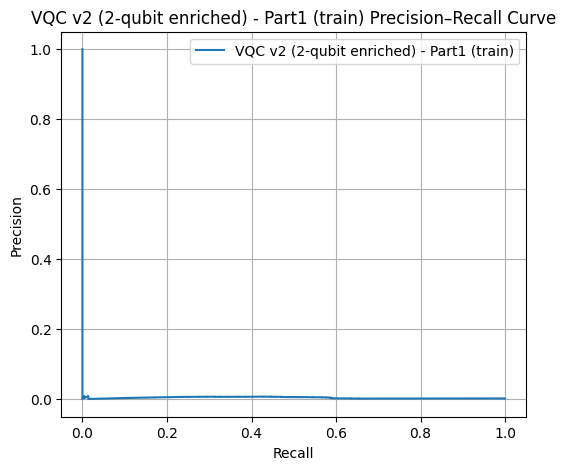

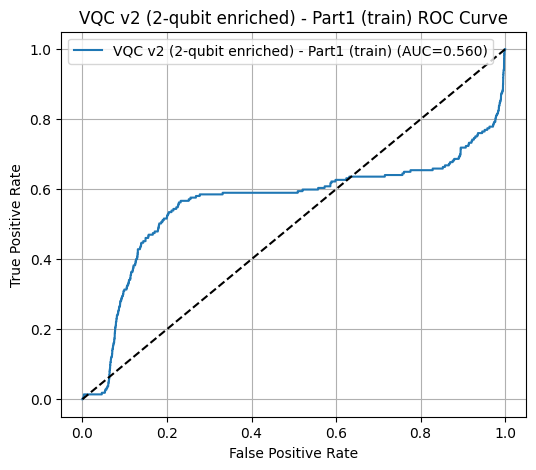


=== VQC v2 (2-qubit enriched) - Part2 (test2) ===

=== VQC v2 (2-qubit enriched) - Part2 (test2) ===
Precision: 0.0047
Recall:    0.2810
F1-score:  0.0093
ROC-AUC:   0.5927

Confusion matrix:
[[85713  9070]
 [  110    43]]

Classification report:
              precision    recall  f1-score   support

           0     0.9987    0.9043    0.9492     94783
           1     0.0047    0.2810    0.0093       153

    accuracy                         0.9033     94936
   macro avg     0.5017    0.5927    0.4792     94936
weighted avg     0.9971    0.9033    0.9477     94936



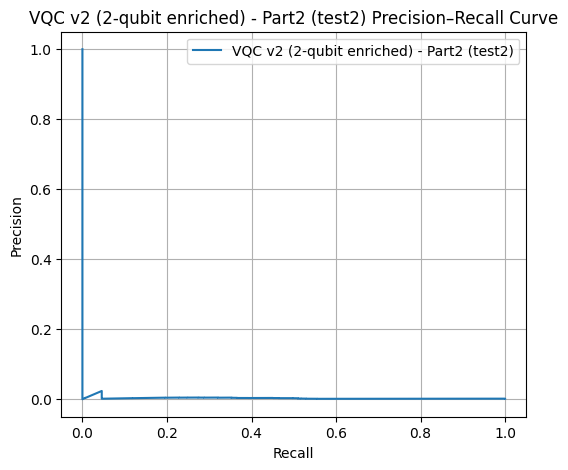

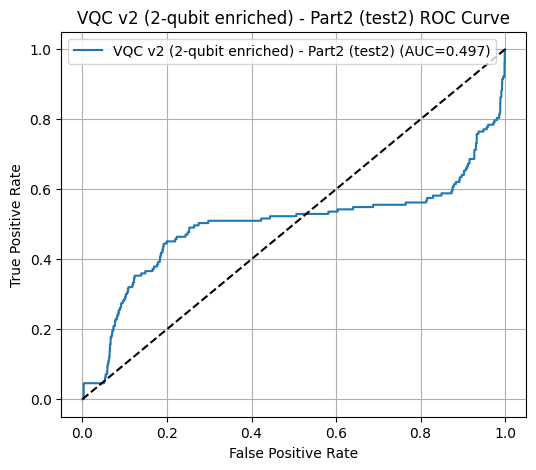


=== VQC v2 (2-qubit enriched) - Part3 (test3) ===

=== VQC v2 (2-qubit enriched) - Part3 (test3) ===
Precision: 0.0059
Recall:    0.4590
F1-score:  0.0116
ROC-AUC:   0.6796

Confusion matrix:
[[85352  9461]
 [   66    56]]

Classification report:
              precision    recall  f1-score   support

           0     0.9992    0.9002    0.9471     94813
           1     0.0059    0.4590    0.0116       122

    accuracy                         0.8996     94935
   macro avg     0.5026    0.6796    0.4794     94935
weighted avg     0.9980    0.8996    0.9459     94935



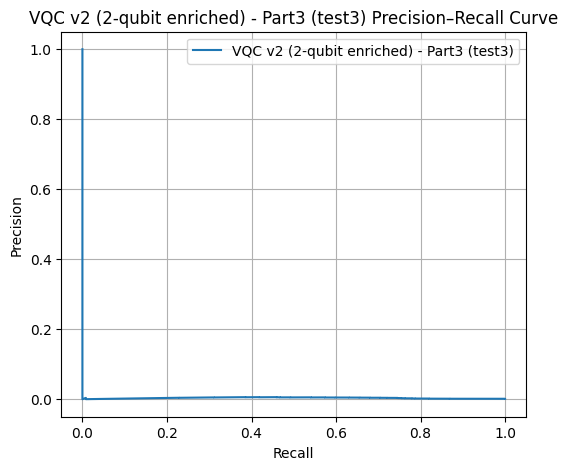

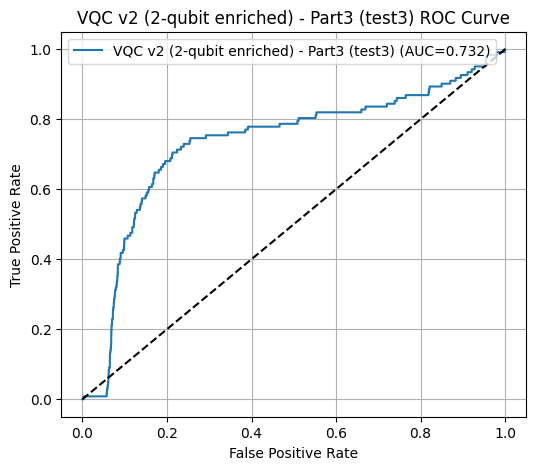

In [11]:
# =======================================================
# Improved VQC v2: 2-qubit enriched classifier (Part1+Part2)
# =======================================================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# ---------- 1) Enriched features and quantum angles ----------

ae_norm = normalize_scores(ae_mse)
if_norm = normalize_scores(iso_scores)

# Enriched classical feature space: latent + AE score + IF score
X_enriched = np.column_stack([
    X_bottleneck,
    ae_norm.reshape(-1, 1),
    if_norm.reshape(-1, 1)
])

# PCA -> 2 dims for 2-qubit circuit
pca_2 = PCA(n_components=2, random_state=42)
X_pca2 = pca_2.fit_transform(X_enriched)   # shape (N,2)

# Scale to [-pi, pi]
min_v = X_pca2.min(axis=0)
max_v = X_pca2.max(axis=0)
X_q_angles = ((X_pca2 - min_v) / (max_v - min_v + 1e-12)) * (2 * np.pi) - np.pi

y_all = y_true.astype(np.float32)

# ---------- 2) Build SMALL training subset from Part1 + Part2 ----------

# indices for Part1 and Part2
idx1 = np.arange(idx_train.start, idx_train.stop)
idx2 = np.arange(idx_test2.start, idx_test2.stop)

y_part1 = y_all[idx_train]
y_part2 = y_all[idx_test2]

fraud_idx_1 = idx1[y_part1 == 1]
fraud_idx_2 = idx2[y_part2 == 1]

normal_idx_1 = idx1[y_part1 == 0]
normal_idx_2 = idx2[y_part2 == 0]

rng = np.random.default_rng(42)

# sample normals from both Part1 and Part2
n_normals_1 = min(400, len(normal_idx_1))
n_normals_2 = min(400, len(normal_idx_2))

normal_sample_1 = rng.choice(normal_idx_1, size=n_normals_1, replace=False)
normal_sample_2 = rng.choice(normal_idx_2, size=n_normals_2, replace=False)

sel_idx = np.concatenate([
    fraud_idx_1,
    fraud_idx_2,
    normal_sample_1,
    normal_sample_2
])

X_vqc_sel = X_q_angles[sel_idx]
y_vqc_sel = y_all[sel_idx]

print("VQC v2 train subset shape:", X_vqc_sel.shape)
print("Frauds in subset:", (y_vqc_sel == 1).sum(),
      "Normals:", (y_vqc_sel == 0).sum())

# Train/val split
X_train_q, X_val_q, y_train_q, y_val_q = train_test_split(
    X_vqc_sel, y_vqc_sel,
    test_size=0.2,
    stratify=y_vqc_sel,
    random_state=42
)

X_train_t = torch.tensor(X_train_q, dtype=torch.float32)
y_train_t = torch.tensor(y_train_q, dtype=torch.float32).view(-1, 1)

X_val_t = torch.tensor(X_val_q, dtype=torch.float32)
y_val_t = torch.tensor(y_val_q, dtype=torch.float32).view(-1, 1)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False)

# ---------- 3) Define 2-qubit VQC with reps=2 ----------

n_qubits = 2

feature_map_vqc = ZZFeatureMap(feature_dimension=n_qubits, reps=1)
ansatz_vqc = TwoLocal(
    n_qubits,
    rotation_blocks=['ry', 'rz'],
    entanglement_blocks='cx',
    reps=2        # <-- slightly deeper circuit
)
vqc_circuit = feature_map_vqc.compose(ansatz_vqc)

estimator = Estimator()
observable_vqc = SparsePauliOp('Z' * n_qubits)  # "ZZ"

vqc_qnn = EstimatorQNN(
    circuit=vqc_circuit,
    estimator=estimator,
    observables=[observable_vqc],
    input_params=feature_map_vqc.parameters,
    weight_params=ansatz_vqc.parameters,
)

vqc_torch = TorchConnector(vqc_qnn)


class VQCClassifier(nn.Module):
    def __init__(self, vqc_module):
        super().__init__()
        self.vqc = vqc_module

    def forward(self, x):
        q_out = self.vqc(x)  # (batch,) or (batch,1), in [-1,1]
        if q_out.dim() == 1:
            q_out = q_out.view(-1, 1)
        p = (q_out + 1.0) / 2.0
        p = torch.clamp(p, 1e-6, 1.0 - 1e-6)
        logits = torch.log(p / (1.0 - p))
        return logits


vqc_model = VQCClassifier(vqc_torch)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(vqc_model.parameters(), lr=1e-3)

# ---------- 4) Train VQC v2 ----------

num_epochs = 5   # still small; you can try 3–5 safely

for epoch in range(num_epochs):
    vqc_model.train()
    train_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = vqc_model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_loader.dataset)

    vqc_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = vqc_model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - train_loss={train_loss:.4f} - val_loss={val_loss:.4f}")

# ---------- 5) VQC scores on ALL data ----------

vqc_model.eval()
with torch.no_grad():
    X_all_t = torch.tensor(X_q_angles, dtype=torch.float32)
    logits_all = vqc_model(X_all_t)
    probs_all = torch.sigmoid(logits_all).cpu().numpy().reshape(-1)

vqc_scores = probs_all    # store this for ensemble
vqc_norm   = normalize_scores(vqc_scores)

# ---------- 6) Threshold tuning on Part1 only ----------

scores_train_vqc = vqc_scores[idx_train]
labels_train_vqc = y_true[idx_train]

percentiles = np.linspace(90, 99.9, 50)
best_f1 = -1
best_p = None
best_thr = None
best_prec = None
best_rec = None

for p in percentiles:
    thr = np.percentile(scores_train_vqc, p)
    preds = (scores_train_vqc > thr).astype(int)
    prec = precision_score(labels_train_vqc, preds, zero_division=0)
    rec  = recall_score(labels_train_vqc, preds, zero_division=0)
    f1   = f1_score(labels_train_vqc, preds, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_p = p
        best_thr = thr
        best_prec = prec
        best_rec = rec

print(f"\n[VQC v2 (2-qubit) threshold tuning - Part1 only]")
print(f"Best percentile: {best_p:.2f}")
print(f"Best threshold:  {best_thr:.4f}")
print(f"Precision:       {best_prec:.4f}")
print(f"Recall:          {best_rec:.4f}")
print(f"F1-score:        {best_f1:.4f}")

vqc_thresh = best_thr
y_pred_vqc_all = (vqc_scores > vqc_thresh).astype(int)

print(f"\nVQC v2 (2-qubit) anomalies: {(y_pred_vqc_all == 1).sum()} / {len(y_pred_vqc_all)}")

# ---------- 7) Evaluate by part ----------

def eval_vqc_split(name, sl):
    y_split = y_true[sl]
    s_split = vqc_scores[sl]
    y_pred_split = y_pred_vqc_all[sl]
    print(f"\n=== VQC v2 (2-qubit enriched) - {name} ===")
    _ = evaluate_model(f"VQC v2 (2-qubit enriched) - {name}", y_split, y_pred_split)
    plot_curves(f"VQC v2 (2-qubit enriched) - {name}", y_split, s_split)

eval_vqc_split("Part1 (train)", idx_train)
eval_vqc_split("Part2 (test2)", idx_test2)
eval_vqc_split("Part3 (test3)", idx_test3)



[AE+IF Ensemble threshold tuning (Part1 only)]
Best percentile: 99.70
Best threshold:  0.1947
Precision:       0.1742
Recall:          0.2304
F1-score:        0.1984

=== AE+IF Ensemble (tuned) - Part1 (train) ===

=== AE+IF Ensemble (tuned) - Part1 (train) ===
Precision: 0.1742
Recall:    0.2304
F1-score:  0.1984
ROC-AUC:   0.6140

Confusion matrix:
[[94482   237]
 [  167    50]]

Classification report:
              precision    recall  f1-score   support

           0     0.9982    0.9975    0.9979     94719
           1     0.1742    0.2304    0.1984       217

    accuracy                         0.9957     94936
   macro avg     0.5862    0.6140    0.5981     94936
weighted avg     0.9964    0.9957    0.9960     94936



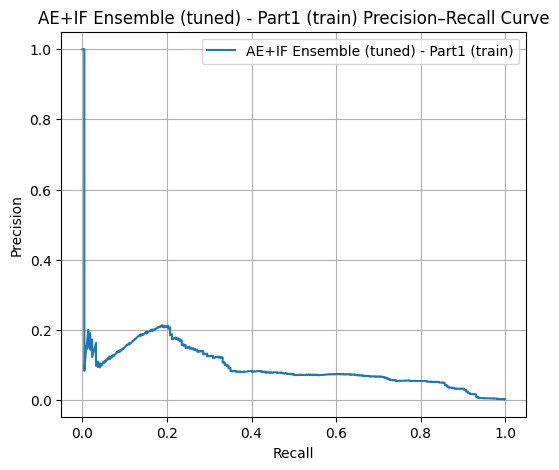

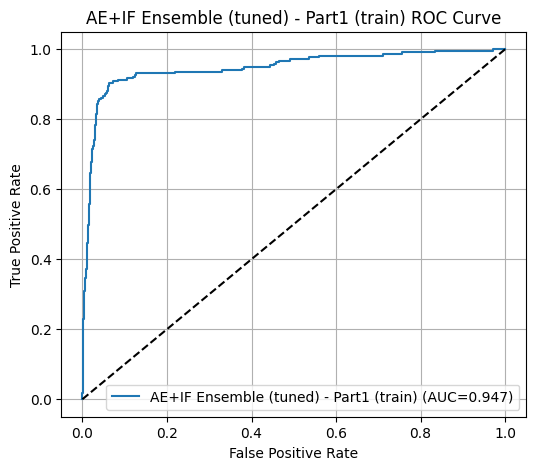


=== AE+IF Ensemble (tuned) - Part2 (test2) ===

=== AE+IF Ensemble (tuned) - Part2 (test2) ===
Precision: 0.1549
Recall:    0.2288
F1-score:  0.1847
ROC-AUC:   0.6134

Confusion matrix:
[[94592   191]
 [  118    35]]

Classification report:
              precision    recall  f1-score   support

           0     0.9988    0.9980    0.9984     94783
           1     0.1549    0.2288    0.1847       153

    accuracy                         0.9967     94936
   macro avg     0.5768    0.6134    0.5915     94936
weighted avg     0.9974    0.9967    0.9971     94936



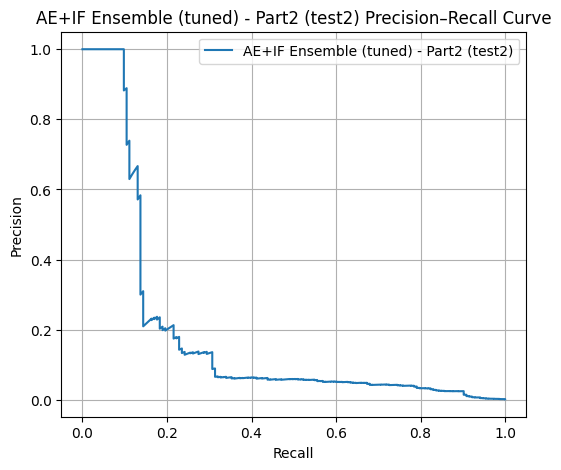

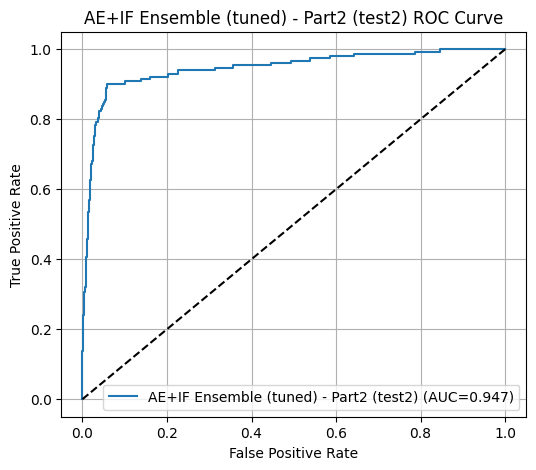


=== AE+IF Ensemble (tuned) - Part3 (test3) ===

=== AE+IF Ensemble (tuned) - Part3 (test3) ===
Precision: 0.0039
Recall:    0.0082
F1-score:  0.0053
ROC-AUC:   0.5028

Confusion matrix:
[[94560   253]
 [  121     1]]

Classification report:
              precision    recall  f1-score   support

           0     0.9987    0.9973    0.9980     94813
           1     0.0039    0.0082    0.0053       122

    accuracy                         0.9961     94935
   macro avg     0.5013    0.5028    0.5017     94935
weighted avg     0.9974    0.9961    0.9968     94935



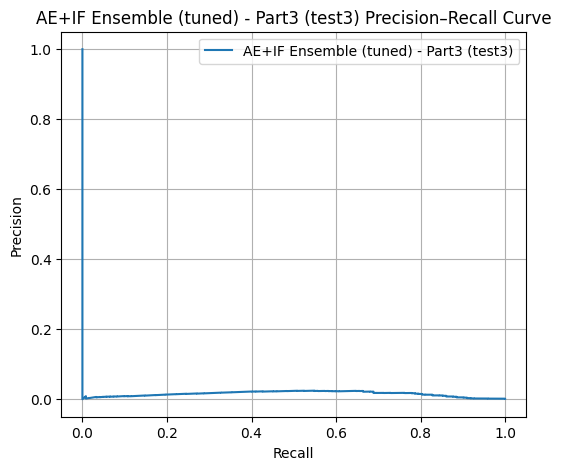

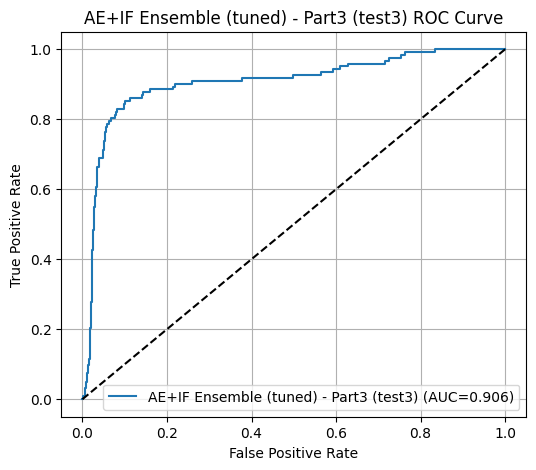


[AE+IF+VQC Ensemble threshold tuning (Part1 only)]
Best percentile: 98.69
Best threshold:  0.1933
Precision:       0.1043
Recall:          0.5991
F1-score:        0.1777

=== AE+IF+VQC Ensemble (tuned) - Part1 (train) ===

=== AE+IF+VQC Ensemble (tuned) - Part1 (train) ===
Precision: 0.1043
Recall:    0.5991
F1-score:  0.1777
ROC-AUC:   0.7936

Confusion matrix:
[[93603  1116]
 [   87   130]]

Classification report:
              precision    recall  f1-score   support

           0     0.9991    0.9882    0.9936     94719
           1     0.1043    0.5991    0.1777       217

    accuracy                         0.9873     94936
   macro avg     0.5517    0.7936    0.5857     94936
weighted avg     0.9970    0.9873    0.9918     94936



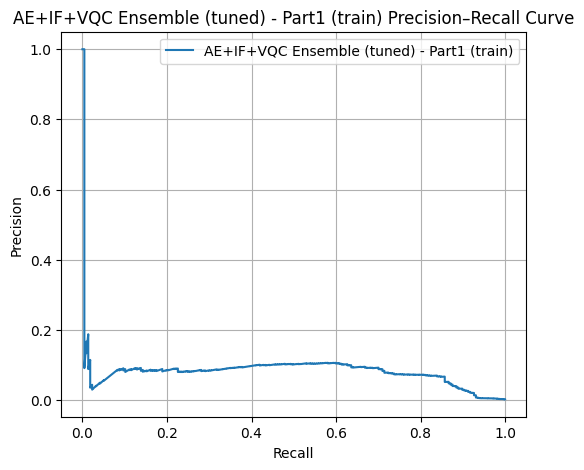

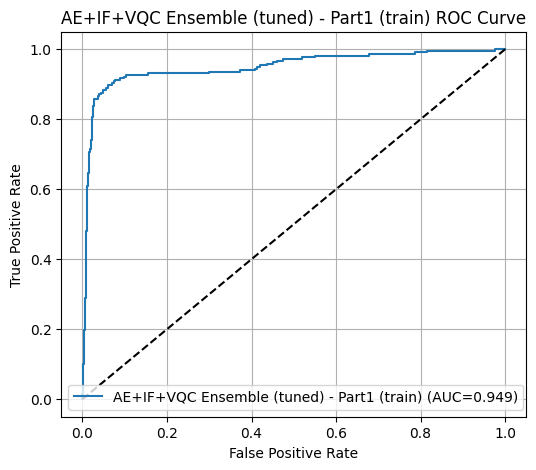


=== AE+IF+VQC Ensemble (tuned) - Part2 (test2) ===

=== AE+IF+VQC Ensemble (tuned) - Part2 (test2) ===
Precision: 0.0711
Recall:    0.5294
F1-score:  0.1253
ROC-AUC:   0.7591

Confusion matrix:
[[93724  1059]
 [   72    81]]

Classification report:
              precision    recall  f1-score   support

           0     0.9992    0.9888    0.9940     94783
           1     0.0711    0.5294    0.1253       153

    accuracy                         0.9881     94936
   macro avg     0.5351    0.7591    0.5596     94936
weighted avg     0.9977    0.9881    0.9926     94936



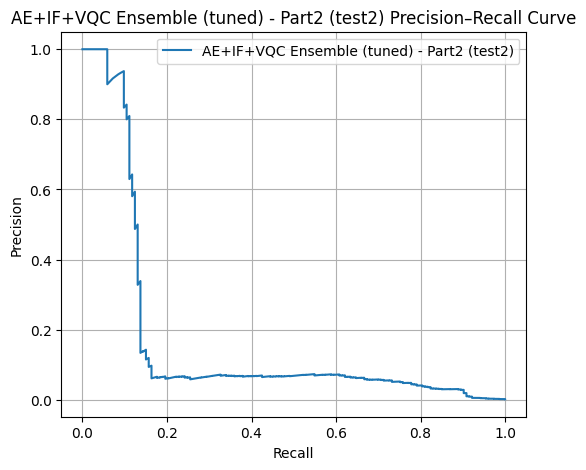

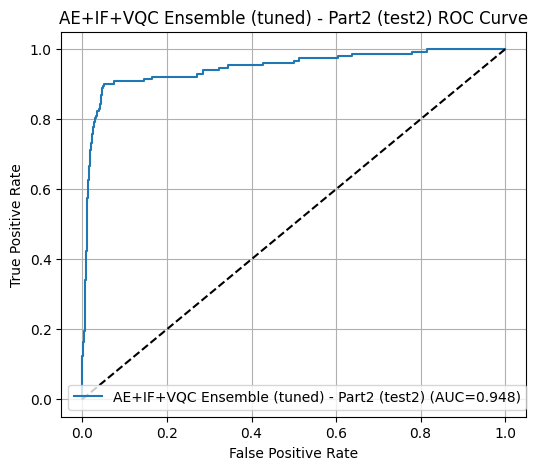


=== AE+IF+VQC Ensemble (tuned) - Part3 (test3) ===

=== AE+IF+VQC Ensemble (tuned) - Part3 (test3) ===
Precision: 0.0202
Recall:    0.2295
F1-score:  0.0372
ROC-AUC:   0.6076

Confusion matrix:
[[93457  1356]
 [   94    28]]

Classification report:
              precision    recall  f1-score   support

           0     0.9990    0.9857    0.9923     94813
           1     0.0202    0.2295    0.0372       122

    accuracy                         0.9847     94935
   macro avg     0.5096    0.6076    0.5147     94935
weighted avg     0.9977    0.9847    0.9911     94935



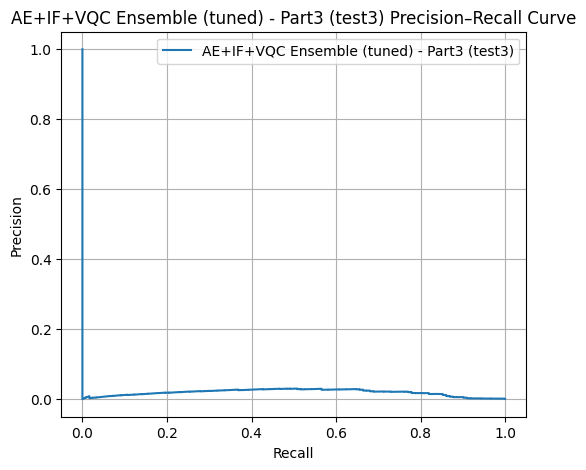

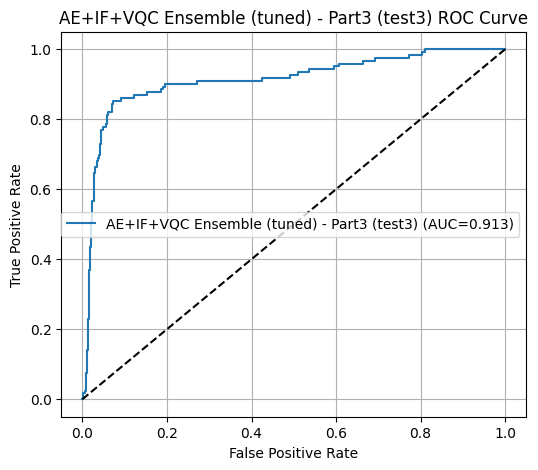

In [12]:
# ============================================
# Hybrid Ensemble: AE + IF + VQC v2
# ============================================

# Make sure these exist:
#   ae_norm  = normalize_scores(ae_mse)
#   if_norm  = normalize_scores(iso_scores)
#   vqc_norm = normalize_scores(vqc_scores)
#   y_true, idx_train, idx_test2, idx_test3

def tune_threshold_part1(scores_all, name=""):
    scores_train = scores_all[idx_train]
    labels_train = y_true[idx_train]

    percentiles = np.linspace(90, 99.9, 50)
    best_f1 = -1
    best_p = None
    best_thr = None
    best_prec = None
    best_rec = None

    for p in percentiles:
        thr = np.percentile(scores_train, p)
        preds = (scores_train > thr).astype(int)
        prec = precision_score(labels_train, preds, zero_division=0)
        rec  = recall_score(labels_train, preds, zero_division=0)
        f1   = f1_score(labels_train, preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_p = p
            best_thr = thr
            best_prec = prec
            best_rec = rec

    print(f"\n[{name} threshold tuning (Part1 only)]")
    print(f"Best percentile: {best_p:.2f}")
    print(f"Best threshold:  {best_thr:.4f}")
    print(f"Precision:       {best_prec:.4f}")
    print(f"Recall:          {best_rec:.4f}")
    print(f"F1-score:        {best_f1:.4f}")

    return best_thr

def eval_split(model_name, scores_all, thr):
    splits = [
        ("Part1 (train)", idx_train),
        ("Part2 (test2)", idx_test2),
        ("Part3 (test3)", idx_test3),
    ]
    for split_name, sl in splits:
        y_split = y_true[sl]
        s_split = scores_all[sl]
        y_pred_split = (s_split > thr).astype(int)
        print(f"\n=== {model_name} - {split_name} ===")
        _ = evaluate_model(f"{model_name} - {split_name}", y_split, y_pred_split)
        plot_curves(f"{model_name} - {split_name}", y_split, s_split)

# --- Ensemble 1: AE + IF only ---
w_ae1  = 0.8
w_if1  = 0.2

ens1_scores = w_ae1 * ae_norm + w_if1 * if_norm
ens1_thr = tune_threshold_part1(ens1_scores, name="AE+IF Ensemble")
eval_split("AE+IF Ensemble (tuned)", ens1_scores, ens1_thr)

# --- Ensemble 2: AE + IF + VQC v2 ---
w_ae2  = 0.7
w_if2  = 0.2
w_vqc2 = 0.1

ens2_scores = w_ae2 * ae_norm + w_if2 * if_norm + w_vqc2 * vqc_norm
ens2_thr = tune_threshold_part1(ens2_scores, name="AE+IF+VQC Ensemble")
eval_split("AE+IF+VQC Ensemble (tuned)", ens2_scores, ens2_thr)


VQC train subset shape: (917, 2)
Frauds in subset: 217 Normals: 700
Epoch 1/5 - train_loss=0.6823 - val_loss=0.6792
Epoch 2/5 - train_loss=0.6578 - val_loss=0.6537
Epoch 3/5 - train_loss=0.6353 - val_loss=0.6303
Epoch 4/5 - train_loss=0.6150 - val_loss=0.6091
Epoch 5/5 - train_loss=0.5968 - val_loss=0.5892

[VQC (2-qubit) threshold tuning - Part1 only]
Best percentile: 99.90
Best threshold:  0.7143
Precision:       0.0105
Recall:          0.0046
F1-score:        0.0064

VQC (2-qubit) anomalies: 343 / 284807

=== VQC (2-qubit enriched) - Part1 (train) ===

=== VQC (2-qubit enriched) - Part1 (train) ===
Precision: 0.0105
Recall:    0.0046
F1-score:  0.0064
ROC-AUC:   0.5018

Confusion matrix:
[[94625    94]
 [  216     1]]

Classification report:
              precision    recall  f1-score   support

           0     0.9977    0.9990    0.9984     94719
           1     0.0105    0.0046    0.0064       217

    accuracy                         0.9967     94936
   macro avg     0.5041    

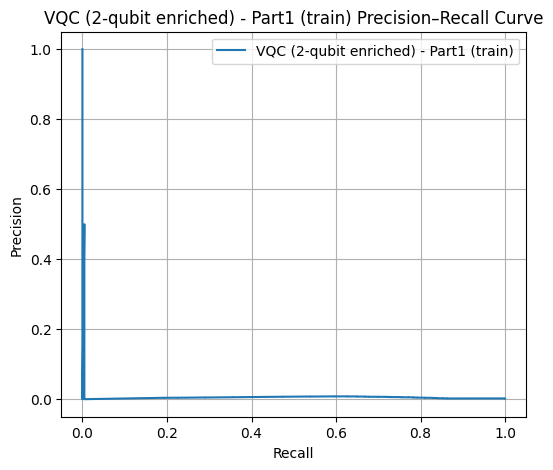

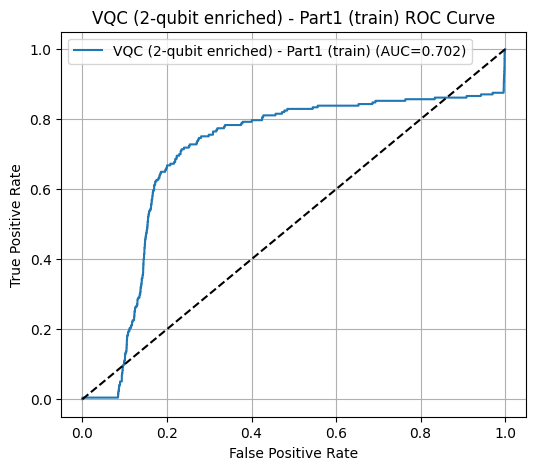


=== VQC (2-qubit enriched) - Part2 (test2) ===

=== VQC (2-qubit enriched) - Part2 (test2) ===
Precision: 0.0545
Recall:    0.0392
F1-score:  0.0456
ROC-AUC:   0.5191

Confusion matrix:
[[94679   104]
 [  147     6]]

Classification report:
              precision    recall  f1-score   support

           0     0.9984    0.9989    0.9987     94783
           1     0.0545    0.0392    0.0456       153

    accuracy                         0.9974     94936
   macro avg     0.5265    0.5191    0.5222     94936
weighted avg     0.9969    0.9974    0.9971     94936



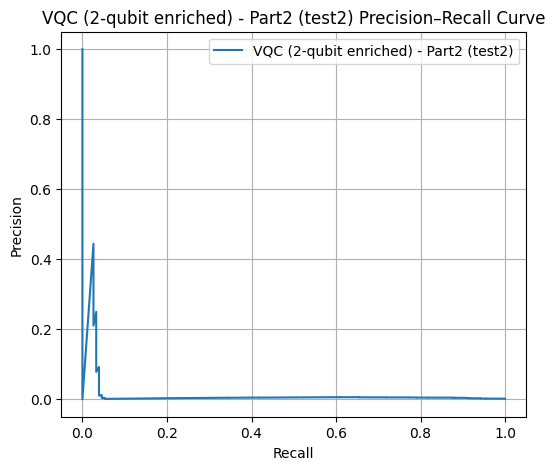

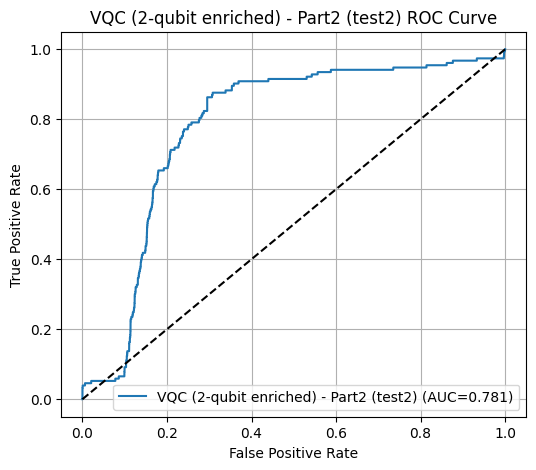


=== VQC (2-qubit enriched) - Part3 (test3) ===

=== VQC (2-qubit enriched) - Part3 (test3) ===
Precision: 0.0072
Recall:    0.0082
F1-score:  0.0077
ROC-AUC:   0.5034

Confusion matrix:
[[94676   137]
 [  121     1]]

Classification report:
              precision    recall  f1-score   support

           0     0.9987    0.9986    0.9986     94813
           1     0.0072    0.0082    0.0077       122

    accuracy                         0.9973     94935
   macro avg     0.5030    0.5034    0.5032     94935
weighted avg     0.9974    0.9973    0.9974     94935



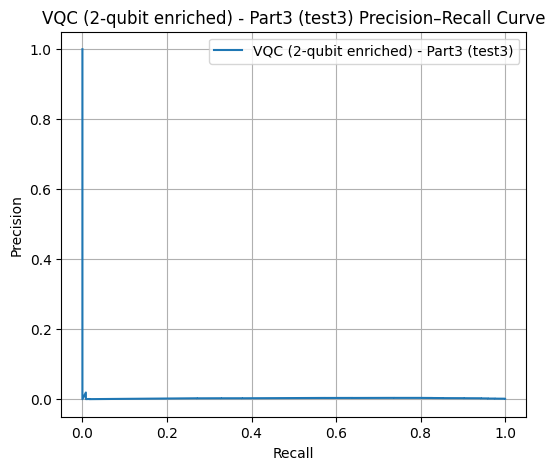

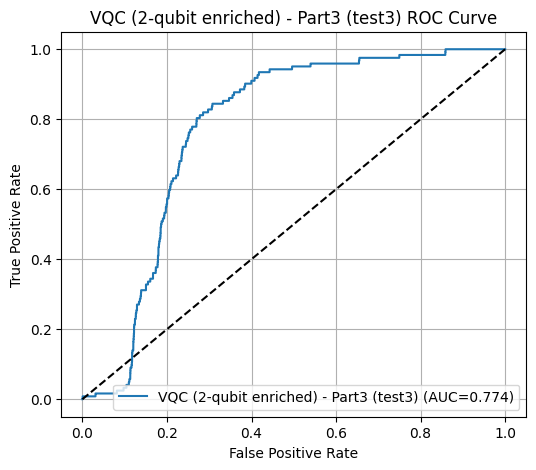

In [13]:
# ============================================
# 2-Qubit VQC: lightweight supervised classifier
# Uses enriched features: [latent, AE score, IF score] -> PCA2 -> angles
# ============================================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# ---------- 1) Build enriched features and quantum angles ----------

# Normalize AE & IF anomaly scores
ae_norm = normalize_scores(ae_mse)
if_norm = normalize_scores(iso_scores)

# Enriched feature space: AE latent + AE score + IF score
X_enriched = np.column_stack([X_bottleneck, ae_norm.reshape(-1, 1), if_norm.reshape(-1, 1)])

# PCA -> 2 dims for 2 qubits
pca_2 = PCA(n_components=2, random_state=42)
X_pca2 = pca_2.fit_transform(X_enriched)  # shape (N, 2)

# Scale to [-pi, pi] for angle embedding
min_v = X_pca2.min(axis=0)
max_v = X_pca2.max(axis=0)
X_q_angles = ((X_pca2 - min_v) / (max_v - min_v + 1e-12)) * (2 * np.pi) - np.pi  # (N, 2)

y_all = y_true.astype(np.float32)

# ---------- 2) Build a SMALL Part1 train subset for VQC ----------

# Indices belonging to Part1
part1_idx = np.arange(idx_train.start, idx_train.stop)
y_part1 = y_all[idx_train]

fraud_idx = part1_idx[y_part1 == 1]
normal_idx = part1_idx[y_part1 == 0]

# Use all fraud + a small sample of normals
n_normals_sample = min(700, len(normal_idx))
rng = np.random.default_rng(42)
normal_sample_idx = rng.choice(normal_idx, size=n_normals_sample, replace=False)

sel_idx = np.concatenate([fraud_idx, normal_sample_idx])

X_vqc_sel = X_q_angles[sel_idx]
y_vqc_sel = y_all[sel_idx]

print("VQC train subset shape:", X_vqc_sel.shape)
print("Frauds in subset:", (y_vqc_sel == 1).sum(), "Normals:", (y_vqc_sel == 0).sum())

# Train/val split on the small subset
X_train_q, X_val_q, y_train_q, y_val_q = train_test_split(
    X_vqc_sel, y_vqc_sel,
    test_size=0.2,
    stratify=y_vqc_sel,
    random_state=42
)

X_train_t = torch.tensor(X_train_q, dtype=torch.float32)
y_train_t = torch.tensor(y_train_q, dtype=torch.float32).view(-1, 1)

X_val_t = torch.tensor(X_val_q, dtype=torch.float32)
y_val_t = torch.tensor(y_val_q, dtype=torch.float32).view(-1, 1)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False)

# ---------- 3) Define 2-qubit VQC classifier ----------

n_qubits = 2

feature_map_vqc = ZZFeatureMap(feature_dimension=n_qubits, reps=1)
ansatz_vqc = TwoLocal(
    n_qubits,
    rotation_blocks=['ry', 'rz'],
    entanglement_blocks='cx',
    reps=1
)
vqc_circuit = feature_map_vqc.compose(ansatz_vqc)

estimator = Estimator()
observable_vqc = SparsePauliOp('Z' * n_qubits)  # "ZZ"

vqc_qnn = EstimatorQNN(
    circuit=vqc_circuit,
    estimator=estimator,
    observables=[observable_vqc],
    input_params=feature_map_vqc.parameters,
    weight_params=ansatz_vqc.parameters,
)

vqc_torch = TorchConnector(vqc_qnn)


class VQCClassifier(nn.Module):
    """
    2-qubit VQC binary classifier.
    Input: angles (batch, 2), output: logits for BCEWithLogitsLoss.
    """
    def __init__(self, vqc_module):
        super().__init__()
        self.vqc = vqc_module

    def forward(self, x):
        q_out = self.vqc(x)  # (batch,) or (batch,1), in [-1,1]
        if q_out.dim() == 1:
            q_out = q_out.view(-1, 1)
        # Map expectation [-1,1] -> probability in (0,1)
        p = (q_out + 1.0) / 2.0
        p = torch.clamp(p, 1e-6, 1.0 - 1e-6)
        # Convert prob to logits
        logits = torch.log(p / (1.0 - p))
        return logits


vqc_model = VQCClassifier(vqc_torch)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(vqc_model.parameters(), lr=1e-3)

# ---------- 4) Train VQC on the small subset ----------

num_epochs = 5  # keep small for speed & stability

for epoch in range(num_epochs):
    vqc_model.train()
    train_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = vqc_model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    vqc_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = vqc_model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - train_loss={train_loss:.4f} - val_loss={val_loss:.4f}")

# ---------- 5) Evaluate VQC on ALL samples ----------

vqc_model.eval()
with torch.no_grad():
    X_all_t = torch.tensor(X_q_angles, dtype=torch.float32)
    logits_all = vqc_model(X_all_t)
    probs_all = torch.sigmoid(logits_all).cpu().numpy().reshape(-1)

vqc_scores = probs_all  # higher = more likely fraud

# ---------- 6) Threshold tuning on Part1 only ----------

scores_train_vqc = vqc_scores[idx_train]
labels_train_vqc = y_true[idx_train]

percentiles = np.linspace(90, 99.9, 50)
best_f1 = -1
best_p = None
best_thr = None
best_prec = None
best_rec = None

for p in percentiles:
    thr = np.percentile(scores_train_vqc, p)
    preds = (scores_train_vqc > thr).astype(int)
    prec = precision_score(labels_train_vqc, preds, zero_division=0)
    rec  = recall_score(labels_train_vqc, preds, zero_division=0)
    f1   = f1_score(labels_train_vqc, preds, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_p = p
        best_thr = thr
        best_prec = prec
        best_rec = rec

print(f"\n[VQC (2-qubit) threshold tuning - Part1 only]")
print(f"Best percentile: {best_p:.2f}")
print(f"Best threshold:  {best_thr:.4f}")
print(f"Precision:       {best_prec:.4f}")
print(f"Recall:          {best_rec:.4f}")
print(f"F1-score:        {best_f1:.4f}")

vqc_thresh = best_thr
y_pred_vqc_all = (vqc_scores > vqc_thresh).astype(int)

print(f"\nVQC (2-qubit) anomalies: {(y_pred_vqc_all == 1).sum()} / {len(y_pred_vqc_all)}")

# ---------- 7) Evaluate VQC on Part1, Part2, Part3 ----------

def eval_vqc_split(name, sl):
    y_split = y_true[sl]
    s_split = vqc_scores[sl]
    y_pred_split = y_pred_vqc_all[sl]
    print(f"\n=== VQC (2-qubit enriched) - {name} ===")
    _ = evaluate_model(f"VQC (2-qubit enriched) - {name}", y_split, y_pred_split)
    plot_curves(f"VQC (2-qubit enriched) - {name}", y_split, s_split)

eval_vqc_split("Part1 (train)", idx_train)
eval_vqc_split("Part2 (test2)", idx_test2)
eval_vqc_split("Part3 (test3)", idx_test3)
